In [1]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import pandas as pd
from torchmetrics.segmentation import DiceScore


In [3]:
# for GDrive
# !wget https://raw.githubusercontent.com/budikawira/CityScape/main/dataset.py
# !wget https://raw.githubusercontent.com/budikawira/CityScape/main/architecture.py

In [4]:
# from google.colab import drive

# drive.mount("/content/drive")

# TEST_IMG_PATH = "/content/drive/MyDrive/AI/Cityscape/images_prepped_test-20230811T065241Z-001"
# TEST_MASK_PATH = "/content/drive/MyDrive/AI/Cityscape/annotations_prepped_test-20230811T065240Z-001"

# EDA_DS_PATH = "/content/drive/MyDrive/AI/Advance CV - Project 3/Dataset"
# EDA_TRAIN_LABELS = os.path.join(EDA_DS_PATH, "train_labels.csv")
# EDA_TRAIN_FILES = os.path.join(EDA_DS_PATH, "train_files.csv")
# EDA_VAL_FILES = os.path.join(EDA_DS_PATH, "val_files.csv")

# MODEL_PATH = "/content/drive/MyDrive/AI/Advance CV - Project 3/models/UNet"
# MODEL_PATH_FCN8S = "/content/drive/MyDrive/AI/Advance CV - Project 3/models/FCN8s"

In [5]:
TEST_IMG_PATH = "./dataset/bootcamp/test/images"
TEST_MASK_PATH = "./dataset/bootcamp/test/annotations"

EDA_DS_PATH = "./dataset/bootcamp/train"
EDA_TRAIN_LABELS = os.path.join(EDA_DS_PATH, "train_labels.csv")
EDA_TRAIN_FILES = os.path.join(EDA_DS_PATH, "train_files.csv")
EDA_VAL_FILES = os.path.join(EDA_DS_PATH, "val_files.csv")

MODEL_PATH = "./models/UNet"
MODEL_PATH_FCN8S = "./models/FCN8s"

METRIC_PATH = "./metrics"

In [6]:
# use validation images for inference test
labels_df = pd.read_csv(EDA_TRAIN_LABELS)

image_files = os.listdir(TEST_IMG_PATH)
mask_files = os.listdir(TEST_MASK_PATH)

test_files = [x for x in image_files if x in mask_files]

print(f"Test Files: {len(test_files)}, Image: {len(image_files)}, Mask: {len(mask_files)}")

print(labels_df)

Test Files: 101, Image: 101, Mask: 101
    class         label
0       0           sky
1       1      building
2       2          pole
3       3          road
4       4      sidewalk
5       5    vegetation
6       6  traffic sign
7       7         fence
8       8       vehicle
9       9        person
10     10         rider
11     11          void


## Dataset Loading

In [7]:
from dataset import CityScapes
from torch.utils.data import DataLoader

test_datasets = CityScapes(TEST_IMG_PATH, TEST_MASK_PATH, test_files)
test_dataloader = DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=0)

## Engine

In [8]:
from torchmetrics.functional.segmentation import dice_score
from torchmetrics import JaccardIndex
from torchmetrics.classification import MulticlassConfusionMatrix

import time

def inference(batch_tensor, model, device='cuda'):
    """Proper batch inference function that handles all caases"""
    
    #GPU-optimized inference with accurate timing.
    # Initialize CUDA events
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    with torch.no_grad():
        # Ensure correct input dimensions
        if batch_tensor.dim() == 3:  # Single image (C,H,W)
            batch_tensor = batch_tensor.unsqueeze(0)  # Add batch dim
        elif batch_tensor.dim() != 4:  # Not standard 4D input
            raise ValueError(f"Expected 3D or 4D input, got {batch_tensor.dim()}D")
        
        batch_tensor = batch_tensor.to(device)
        
        # Synchronize and record time
        torch.cuda.synchronize()  # Wait for pending GPU ops
        start_event.record()
        logits = model(batch_tensor)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        end_event.record()
        torch.cuda.synchronize()  # Ensure all work is done
        inf_time = start_event.elapsed_time(end_event) / 1000  # Convert ms to seconds

    return logits, probs, preds, inf_time
    
def inferences(model, test_dataloader, labels_df):
    """
    input:
    - model: model
    - test_dataloader: dataloader
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_time = 0
    num_classes = len(labels_df)
    dice_accumulator = torch.zeros(num_classes, device=device)
    dice_counts = torch.zeros(num_classes, device=device)

    
    # Initialize metrics
    jaccard = JaccardIndex(
        task='multiclass',
        num_classes=num_classes,
        ignore_index=None,
        average='none'  # Track per-class IoU
    ).to(device)

    # Initialize confusion metrics
    confmat = MulticlassConfusionMatrix(num_classes=num_classes, normalize='true').to(device)

    batch = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, masks in test_dataloader:
            batch = batch + 1
            print(f"Batch Size: {len(images)}, batch: {batch} of {len(test_dataloader)}")
            images, masks = images.to(device), masks.to(device)
            # Verify shapes
            if batch == 1:
                print("Input shape:", images.shape)  # Should be [B,C,H,W]
                print("Mask shape:", masks.shape)   # Should be [B,H,W]
            
            # Run inference
            logits, probs, preds, inf_time = inference(images, model)
            print(f"Inf time:{inf_time:.4f}")
            preds = preds.to(device).long()
            masks = masks.to(device).long()
            
            # Update Dice (per batch)
            # input_format='index' if masks.shape is [B, H, W]
            # if mask [B, C, H, W] input format='probabilities'
            # Compute per-class Dice
            dice_per_class = dice_score(
                preds, masks,
                num_classes=num_classes,
                average='none',
                input_format='index'
            )
            # Accumulate Dice scores
            # print('dice_per_class')
            # print(dice_per_class)
            dice_batch_sum = dice_per_class.sum(dim=0)  # Sum over batch → shape: [num_classes]
            # print('dice_batch_sum')
            # print(dice_batch_sum)
            dice_accumulator += dice_batch_sum
            dice_counts += dice_per_class.size(0)  # Add batch size

            dice_counts += 1

            # Update IoU (accumulate across batches)
            jaccard.update(preds, masks)

            # Update confusion matrix
            confmat.update(preds.flatten(), masks.flatten())

            
            total_time += inf_time
            print()
            

    iou_per_class = jaccard.compute()
    mIoU = torch.mean(iou_per_class)

    avg_dice_per_class = (dice_accumulator / dice_counts).cpu().numpy().round(4)
    mean_dice = avg_dice_per_class.mean()
    # Compute confusion matrix
    conf_matrix = confmat.compute().cpu().numpy()
    
    print(f"\nDataset Metrics:")
    print(f"- Per-class IoU: {iou_per_class.cpu().numpy().round(4)}")
    print(f"- Mean IoU (mIoU): {mIoU.item():.4f}")
    print(f"- Per-class Dice: {avg_dice_per_class}")
    print(f"- Mean Dice: {mean_dice:.4f}")
    # print(f"- Confusion Matrix: {conf_matrix}")

    print(f"- Total Inference Time: {total_time:.4f}s")

    return iou_per_class.cpu().numpy().round(4), mIoU.item(), avg_dice_per_class, mean_dice, conf_matrix, total_time


## Inference

In [9]:
metrics = []

In [10]:
from architecture import UNET
import torch
from PIL import Image

model = UNET(in_channels=3, out_channels=len(labels_df))
state_dict = torch.load(os.path.join(MODEL_PATH, 'best_model_dice.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
# print("Missing keys:", missing)

iou_per_class, mean_iou, dice_per_class, mean_dice, conf_matrix, total_time = inferences(model,test_dataloader,labels_df)
metrics.append({
    "Architecture": "UNet",
    "Loss Function": "Dice Loss",
    "IoU Score / Class": iou_per_class,
    "Dice Score / Class": dice_per_class,
    "Confusion Matrix": conf_matrix,
    "Mean IoU Score": mean_iou,
    "Mean Dice Score": mean_dice,
    "Total_Time": total_time
})


Batch Size: 32, batch: 1 of 4
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Inf time:0.6242

Batch Size: 32, batch: 2 of 4
Inf time:0.4162

Batch Size: 32, batch: 3 of 4
Inf time:0.4189

Batch Size: 5, batch: 4 of 4
Inf time:0.0714


Dataset Metrics:
- Per-class IoU: [0.9396 0.8072 0.1298 0.9411 0.8086 0.8259 0.3573 0.     0.5731 0.3678
 0.     0.2328]
- Mean IoU (mIoU): 0.4986
- Per-class Dice: [0.9318 0.8536 0.2195 0.9328 0.8583 0.873  0.468  0.     0.5433 0.4717
 0.     0.354 ]
- Mean Dice: 0.5422
- Total Inference Time: 1.5307s


In [11]:
model = UNET(in_channels=3, out_channels=len(labels_df))
state_dict = torch.load(os.path.join(MODEL_PATH, 'best_model_cross.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
# print("Missing keys:", missing)

iou_per_class, mean_iou, dice_per_class, mean_dice, conf_matrix, total_time = inferences(model,test_dataloader,labels_df)
metrics.append({
    "Architecture": "UNet",
    "Loss Function": "Cross Entropy Loss",
    "IoU Score / Class": iou_per_class,
    "Dice Score / Class": dice_per_class,
    "Confusion Matrix": conf_matrix,
    "Mean IoU Score": mean_iou,
    "Mean Dice Score": mean_dice,
    "Total_Time": total_time
})

Batch Size: 32, batch: 1 of 4
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Inf time:0.4151

Batch Size: 32, batch: 2 of 4
Inf time:0.4201

Batch Size: 32, batch: 3 of 4
Inf time:0.4177

Batch Size: 5, batch: 4 of 4
Inf time:0.0595


Dataset Metrics:
- Per-class IoU: [0.9397 0.8482 0.1086 0.9643 0.8603 0.8971 0.0968 0.5138 0.666  0.3519
 0.5072 0.2748]
- Mean IoU (mIoU): 0.5857
- Per-class Dice: [0.9319 0.8782 0.1851 0.9447 0.8848 0.9099 0.1342 0.585  0.5906 0.3944
 0.6436 0.4001]
- Mean Dice: 0.6235
- Total Inference Time: 1.3123s


In [12]:
model = UNET(in_channels=3, out_channels=len(labels_df))
state_dict = torch.load(os.path.join(MODEL_PATH, 'best_model_combined.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
# print("Missing keys:", missing)

iou_per_class, mean_iou, dice_per_class, mean_dice, conf_matrix, total_time = inferences(model,test_dataloader,labels_df)
metrics.append({
    "Architecture": "UNet",
    "Loss Function": "Combined",
    "IoU Score / Class": iou_per_class,
    "Dice Score / Class": dice_per_class,
    "Confusion Matrix": conf_matrix,
    "Mean IoU Score": mean_iou,
    "Mean Dice Score": mean_dice,
    "Total_Time": total_time
})

Batch Size: 32, batch: 1 of 4
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Inf time:0.4206

Batch Size: 32, batch: 2 of 4
Inf time:0.4181

Batch Size: 32, batch: 3 of 4
Inf time:0.4199

Batch Size: 5, batch: 4 of 4
Inf time:0.0581


Dataset Metrics:
- Per-class IoU: [0.9388 0.8378 0.1334 0.966  0.8572 0.886  0.336  0.5125 0.7102 0.3196
 0.4793 0.2744]
- Mean IoU (mIoU): 0.6043
- Per-class Dice: [0.9314 0.8731 0.2195 0.9453 0.8835 0.9051 0.4094 0.5948 0.6244 0.426
 0.6446 0.4056]
- Mean Dice: 0.6552
- Total Inference Time: 1.3168s


In [13]:
from architecture import FCN8s
import torch

model = FCN8s(in_channels=3, out_channels=len(labels_df))
state_dict = torch.load(os.path.join(MODEL_PATH_FCN8S, 'best_model_dice.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
# print("Missing keys:", missing)

iou_per_class, mean_iou, dice_per_class, mean_dice, conf_matrix, total_time = inferences(model,test_dataloader,labels_df)
metrics.append({
    "Architecture": "FCN8s",
    "Loss Function": "Dice Loss",
    "IoU Score / Class": iou_per_class,
    "Dice Score / Class": dice_per_class,
    "Confusion Matrix": conf_matrix,
    "Mean IoU Score": mean_iou,
    "Mean Dice Score": mean_dice,
    "Total_Time": total_time
})

Batch Size: 32, batch: 1 of 4
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Inf time:0.1604

Batch Size: 32, batch: 2 of 4
Inf time:0.1576

Batch Size: 32, batch: 3 of 4
Inf time:0.1582

Batch Size: 5, batch: 4 of 4
Inf time:0.0222


Dataset Metrics:
- Per-class IoU: [0.9249 0.7609 0.1373 0.9365 0.8336 0.8596 0.3775 0.     0.6061 0.2798
 0.     0.2234]
- Mean IoU (mIoU): 0.4950
- Per-class Dice: [0.9242 0.8234 0.2187 0.9302 0.8724 0.8916 0.462  0.     0.5634 0.3815
 0.     0.3409]
- Mean Dice: 0.5340
- Total Inference Time: 0.4984s


In [14]:
from architecture import FCN8s
import torch

model = FCN8s(in_channels=3, out_channels=len(labels_df))
state_dict = torch.load(os.path.join(MODEL_PATH_FCN8S, 'best_model_cross.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
# print("Missing keys:", missing)

iou_per_class, mean_iou, dice_per_class, mean_dice,  conf_matrix, total_time = inferences(model,test_dataloader,labels_df)
metrics.append({
    "Architecture": "FCN8s",
    "Loss Function": "Cross Entropy Loss",
    "IoU Score / Class": iou_per_class,
    "Dice Score / Class": dice_per_class,
    "Confusion Matrix": conf_matrix,
    "Mean IoU Score": mean_iou,
    "Mean Dice Score": mean_dice,
    "Total_Time": total_time
})

Batch Size: 32, batch: 1 of 4
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Inf time:0.1620

Batch Size: 32, batch: 2 of 4
Inf time:0.1597

Batch Size: 32, batch: 3 of 4
Inf time:0.1599

Batch Size: 5, batch: 4 of 4
Inf time:0.0224


Dataset Metrics:
- Per-class IoU: [0.9239 0.8115 0.0703 0.9578 0.8293 0.8709 0.1001 0.4775 0.744  0.2407
 0.4472 0.2394]
- Mean IoU (mIoU): 0.5594
- Per-class Dice: [0.9237 0.8558 0.1222 0.9412 0.8677 0.8969 0.1147 0.5836 0.6556 0.3047
 0.6002 0.3534]
- Mean Dice: 0.6016
- Total Inference Time: 0.5039s


In [15]:
from architecture import FCN8s
import torch

model = FCN8s(in_channels=3, out_channels=len(labels_df))
state_dict = torch.load(os.path.join(MODEL_PATH_FCN8S, 'best_model_combined.pth'), weights_only=True)
missing, unexpected = model.load_state_dict(state_dict)
# print("Missing keys:", missing)

iou_per_class, mean_iou, dice_per_class, mean_dice,  conf_matrix, total_time = inferences(model,test_dataloader,labels_df)
metrics.append({
    "Architecture": "FCN8s",
    "Loss Function": "Combined",
    "IoU Score / Class": iou_per_class,
    "Dice Score / Class": dice_per_class,
    "Confusion Matrix": conf_matrix,
    "Mean IoU Score": mean_iou,
    "Mean Dice Score": mean_dice,
    "Total_Time": total_time
})

Batch Size: 32, batch: 1 of 4
Input shape: torch.Size([32, 3, 256, 256])
Mask shape: torch.Size([32, 256, 256])
Inf time:0.1605

Batch Size: 32, batch: 2 of 4
Inf time:0.1612

Batch Size: 32, batch: 3 of 4
Inf time:0.1634

Batch Size: 5, batch: 4 of 4
Inf time:0.0226


Dataset Metrics:
- Per-class IoU: [0.9278 0.8236 0.0681 0.9584 0.8181 0.8915 0.1692 0.5195 0.76   0.3105
 0.4748 0.1487]
- Mean IoU (mIoU): 0.5725
- Per-class Dice: [0.9257 0.8629 0.1099 0.9415 0.8606 0.9071 0.2281 0.6337 0.706  0.3855
 0.6281 0.2434]
- Mean Dice: 0.6194
- Total Inference Time: 0.5077s


In [16]:
df_metrics = pd.DataFrame(metrics)
inf_metrics_path = os.path.join(METRIC_PATH, "inference_metrics.csv")
df_metrics.to_csv(inf_metrics_path, index=False)

## IoU Score, Dice Score, Total Inference Time (All Dataset) / Model

In [17]:
df_temp = pd.read_csv(inf_metrics_path)
df_temp = df_metrics.drop(['IoU Score / Class', 'Dice Score / Class', 'Confusion Matrix'], axis=1)

In [18]:
df_temp

Architecture       Loss Function  Mean IoU Score  Mean Dice Score  \
0         UNet           Dice Loss        0.498604         0.542167   
1         UNet  Cross Entropy Loss        0.585722         0.623542   
2         UNet            Combined        0.604262         0.655225   
3        FCN8s           Dice Loss        0.494972         0.534025   
4        FCN8s  Cross Entropy Loss        0.559376         0.601642   
5        FCN8s            Combined        0.572518         0.619375   

   Total_Time  
0    1.530740  
1    1.312300  
2    1.316755  
3    0.498394  
4    0.503934  
5    0.507680

C:\Users\budik\AppData\Local\Temp\ipykernel_47716\1626404000.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral')


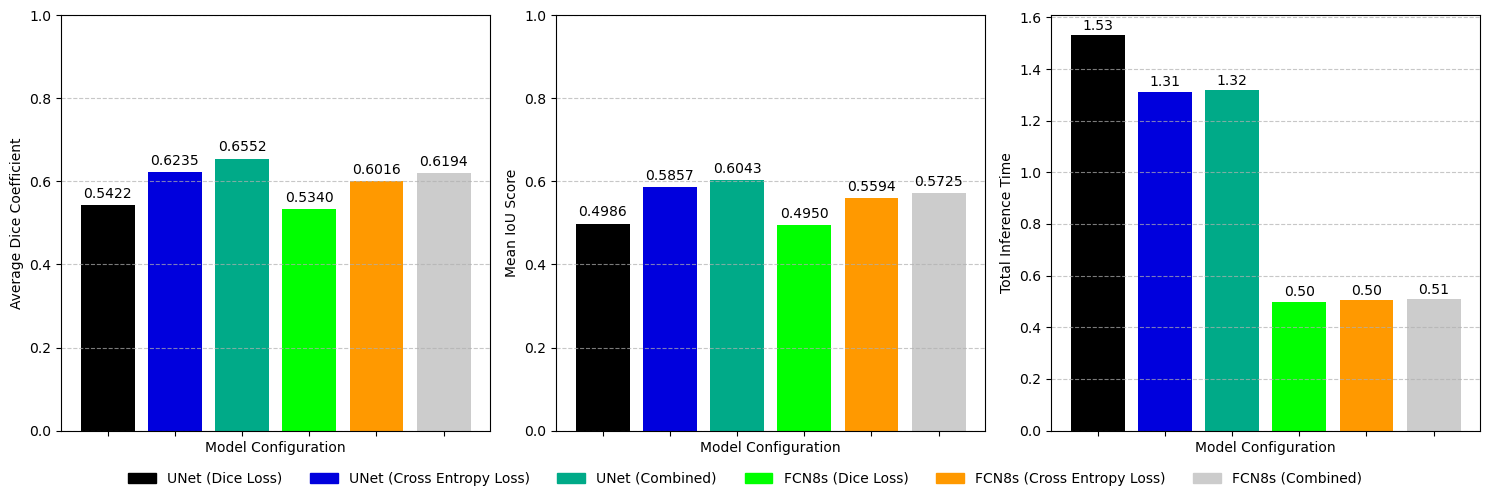

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

df_metrics['Mean Dice Score'].values
# Build legend labels
df_metrics['Label'] = df_metrics['Architecture'] + ' (' + df_metrics['Loss Function'] + ')'

# Setup colormap
cmap = cm.get_cmap('nipy_spectral')
num_models = len(df_metrics)
indices = np.linspace(0, 1, num_models)
colors = [cmap(i) for i in indices]

# Create custom legend handles
legend_handles = [
    mpatches.Patch(color=colors[i], label=df_metrics['Label'].iloc[i])
    for i in range(num_models)
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# 1. Avg_Dice
axes[0].bar(df_metrics['Label'], df_metrics['Mean Dice Score'], color=colors)
axes[0].tick_params(axis='x', labelbottom=False)
axes[0].set_ylabel('Average Dice Coefficient')
axes[0].set_xlabel('Model Configuration')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, val in enumerate(df_metrics['Mean Dice Score']):
    axes[0].text(i, val + 0.01, f"{val:.4f}", ha='center', va='bottom')

# 2. Mean_IoU
axes[1].bar(df_metrics['Label'], df_metrics['Mean IoU Score'], color=colors)
axes[1].tick_params(axis='x', labelbottom=False)
axes[1].set_ylabel('Mean IoU Score')
axes[1].set_xlabel('Model Configuration')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, val in enumerate(df_metrics['Mean IoU Score']):
    axes[1].text(i, val + 0.01, f"{val:.4f}", ha='center', va='bottom')

# 3. Total_Time
axes[2].bar(df_metrics['Label'], df_metrics['Total_Time'], color=colors)
axes[2].tick_params(axis='x', labelbottom=False)
axes[2].set_ylabel('Total Inference Time')
axes[2].set_xlabel('Model Configuration')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
for i, val in enumerate(df_metrics['Total_Time']):
    axes[2].text(i, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

# Add global legend
fig.legend(handles=legend_handles, loc='lower center', ncol=num_models, frameon=False, fontsize='medium')

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for legend
plt.show()



## IoU Per Class / Model

In [20]:
param = 'IoU Score / Class'
df_temp = pd.DataFrame({
    'label': labels_df['label'],
    'UNet (DiceLoss)': df_metrics[param][0],
    'UNet (CrossEntropyLoss)': df_metrics[param][1],
    'UNet (Combined)': df_metrics[param][2],
    'FCN8s (DiceLoss)': df_metrics[param][3],
    'FCN8s (CrossEntropyLoss)': df_metrics[param][4],
    'FCN8s (Combined)': df_metrics[param][5],
})

In [21]:
df_temp

label  UNet (DiceLoss)  UNet (CrossEntropyLoss)  UNet (Combined)  \
0            sky           0.9396                   0.9397           0.9388   
1       building           0.8072                   0.8482           0.8378   
2           pole           0.1298                   0.1086           0.1334   
3           road           0.9411                   0.9643           0.9660   
4       sidewalk           0.8086                   0.8603           0.8572   
5     vegetation           0.8259                   0.8971           0.8860   
6   traffic sign           0.3573                   0.0968           0.3360   
7          fence           0.0000                   0.5138           0.5125   
8        vehicle           0.5731                   0.6660           0.7102   
9         person           0.3678                   0.3519           0.3196   
10         rider           0.0000                   0.5072           0.4793   
11          void           0.2328                   0.2748           0.2744   

    FCN8s (DiceLoss)  FCN8s (CrossEntropyLoss)  FCN8s (Combined)  
0             0.9249                    0.9239            0.9278  
1             0.7609                    0.8115            0.8236  
2             0.1373                    0.0703            0.0681  
3             0.9365                    0.9578            0.9584  
4             0.8336                    0.8293            0.8181  
5             0.8596                    0.8709            0.8915  
6             0.3775                    0.1001            0.1692  
7             0.0000                    0.4775            0.5195  
8             0.6061                    0.7440            0.7600  
9             0.2798                    0.2407            0.3105  
10            0.0000                    0.4472            0.4748  
11            0.2234                    0.2394            0.1487

## Dice Score per Class / Model

In [22]:
param = 'Dice Score / Class'
df_temp = pd.DataFrame({
    'label': labels_df['label'],
    'UNet (DiceLoss)': df_metrics[param][0],
    'UNet (CrossEntropyLoss)': df_metrics[param][1],
    'UNet (Combined)': df_metrics[param][2],
    'FCN8s (DiceLoss)': df_metrics[param][3],
    'FCN8s (CrossEntropyLoss)': df_metrics[param][4],
    'FCN8s (Combined)': df_metrics[param][5],
})

In [23]:
df_temp

label  UNet (DiceLoss)  UNet (CrossEntropyLoss)  UNet (Combined)  \
0            sky           0.9318                   0.9319           0.9314   
1       building           0.8536                   0.8782           0.8731   
2           pole           0.2195                   0.1851           0.2195   
3           road           0.9328                   0.9447           0.9453   
4       sidewalk           0.8583                   0.8848           0.8835   
5     vegetation           0.8730                   0.9099           0.9051   
6   traffic sign           0.4680                   0.1342           0.4094   
7          fence           0.0000                   0.5850           0.5948   
8        vehicle           0.5433                   0.5906           0.6244   
9         person           0.4717                   0.3944           0.4260   
10         rider           0.0000                   0.6436           0.6446   
11          void           0.3540                   0.4001           0.4056   

    FCN8s (DiceLoss)  FCN8s (CrossEntropyLoss)  FCN8s (Combined)  
0             0.9242                    0.9237            0.9257  
1             0.8234                    0.8558            0.8629  
2             0.2187                    0.1222            0.1099  
3             0.9302                    0.9412            0.9415  
4             0.8724                    0.8677            0.8606  
5             0.8916                    0.8969            0.9071  
6             0.4620                    0.1147            0.2281  
7             0.0000                    0.5836            0.6337  
8             0.5634                    0.6556            0.7060  
9             0.3815                    0.3047            0.3855  
10            0.0000                    0.6002            0.6281  
11            0.3409                    0.3534            0.2434

## Confusion Matrix

Architecture                                                       UNet
Loss Function                                                 Dice Loss
IoU Score / Class     [0.9396 0.8072 0.1298 0.9411 0.8086 0.8259 0.3...
Dice Score / Class    [0.9318 0.8536 0.2195 0.9328 0.8583 0.873  0.4...
Confusion Matrix      [[9.70001400e-01 4.48803278e-03 1.20856777e-04...
Mean IoU Score                                                 0.498604
Mean Dice Score                                                0.542167
Total_Time                                                      1.53074
Name: 0, dtype: object


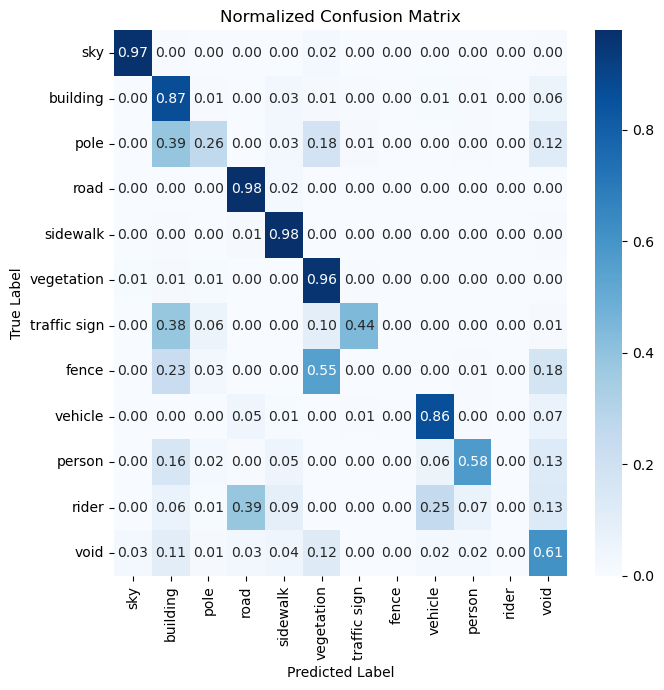



Architecture                                                       UNet
Loss Function                                        Cross Entropy Loss
IoU Score / Class     [0.9397 0.8482 0.1086 0.9643 0.8603 0.8971 0.0...
Dice Score / Class    [0.9319 0.8782 0.1851 0.9447 0.8848 0.9099 0.1...
Confusion Matrix      [[9.73796964e-01 5.12171444e-03 1.63319964e-05...
Mean IoU Score                                                 0.585722
Mean Dice Score                                                0.623542
Total_Time                                                       1.3123
Name: 1, dtype: object


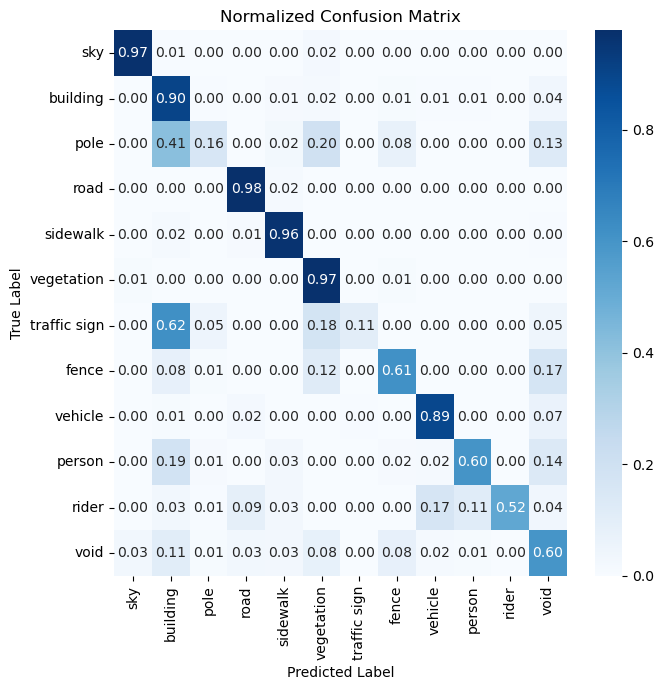



Architecture                                                       UNet
Loss Function                                                  Combined
IoU Score / Class     [0.9388 0.8378 0.1334 0.966  0.8572 0.886  0.3...
Dice Score / Class    [0.9314 0.8731 0.2195 0.9453 0.8835 0.9051 0.4...
Confusion Matrix      [[9.7594953e-01 3.9654090e-03 1.2248998e-04 0....
Mean IoU Score                                                 0.604262
Mean Dice Score                                                0.655225
Total_Time                                                     1.316755
Name: 2, dtype: object


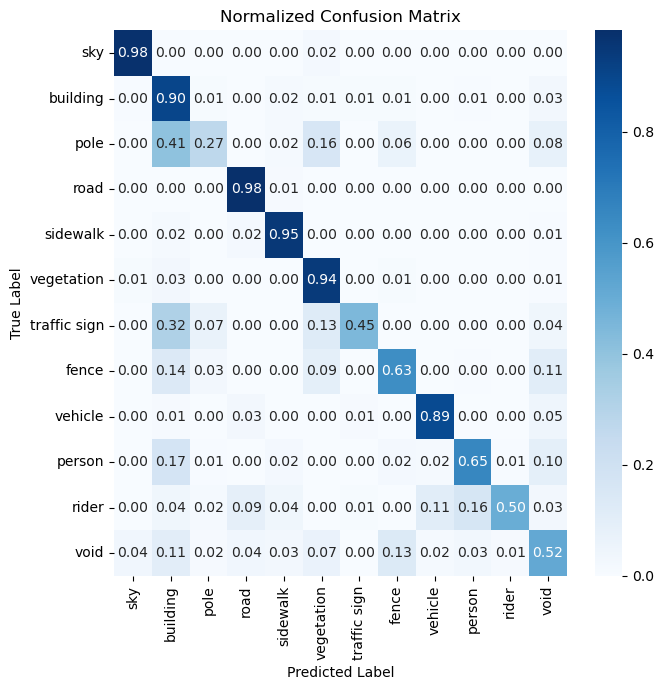



Architecture                                                      FCN8s
Loss Function                                                 Dice Loss
IoU Score / Class     [0.9249 0.7609 0.1373 0.9365 0.8336 0.8596 0.3...
Dice Score / Class    [0.9242 0.8234 0.2187 0.9302 0.8724 0.8916 0.4...
Confusion Matrix      [[9.49508011e-01 8.95483419e-03 1.25756371e-04...
Mean IoU Score                                                 0.494972
Mean Dice Score                                                0.534025
Total_Time                                                     0.498394
Name: 3, dtype: object


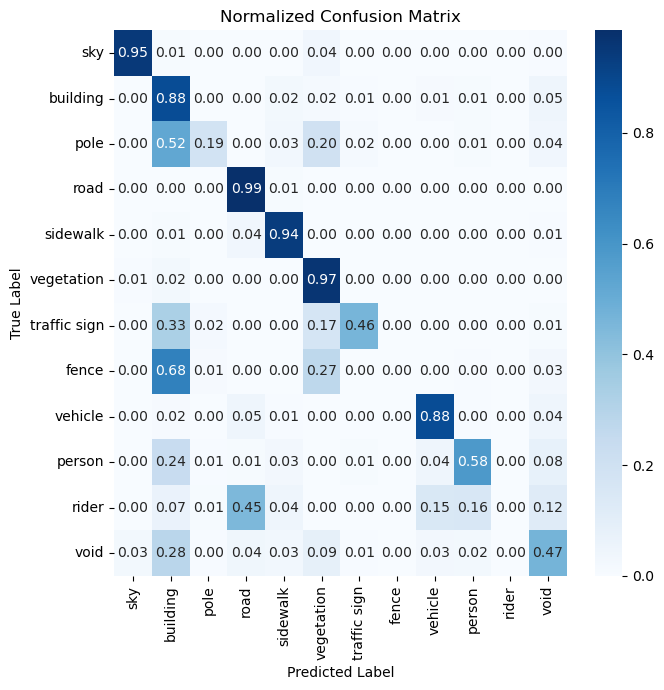



Architecture                                                      FCN8s
Loss Function                                        Cross Entropy Loss
IoU Score / Class     [0.9239 0.8115 0.0703 0.9578 0.8293 0.8709 0.1...
Dice Score / Class    [0.9237 0.8558 0.1222 0.9412 0.8677 0.8969 0.1...
Confusion Matrix      [[9.51688349e-01 1.14258649e-02 3.26639929e-06...
Mean IoU Score                                                 0.559376
Mean Dice Score                                                0.601642
Total_Time                                                     0.503934
Name: 4, dtype: object


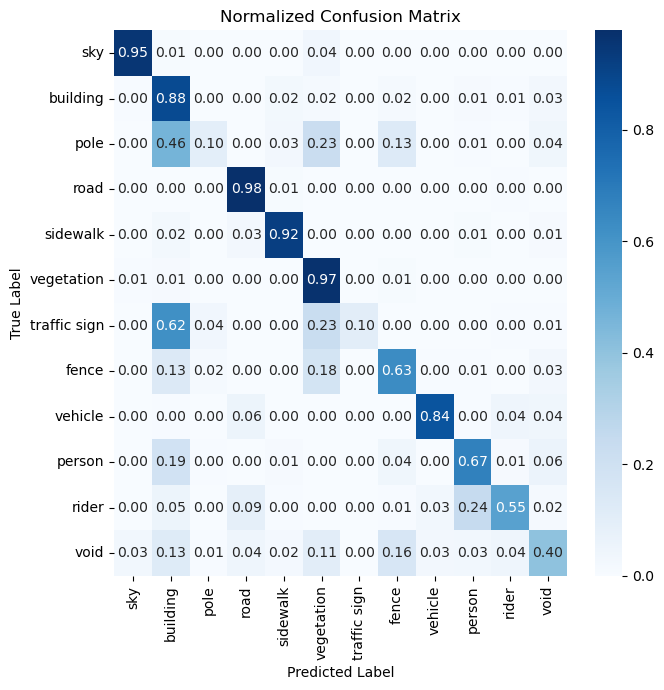



Architecture                                                      FCN8s
Loss Function                                                  Combined
IoU Score / Class     [0.9278 0.8236 0.0681 0.9584 0.8181 0.8915 0.1...
Dice Score / Class    [0.9257 0.8629 0.1099 0.9415 0.8606 0.9071 0.2...
Confusion Matrix      [[9.58052874e-01 7.15668080e-03 0.00000000e+00...
Mean IoU Score                                                 0.572518
Mean Dice Score                                                0.619375
Total_Time                                                      0.50768
Name: 5, dtype: object


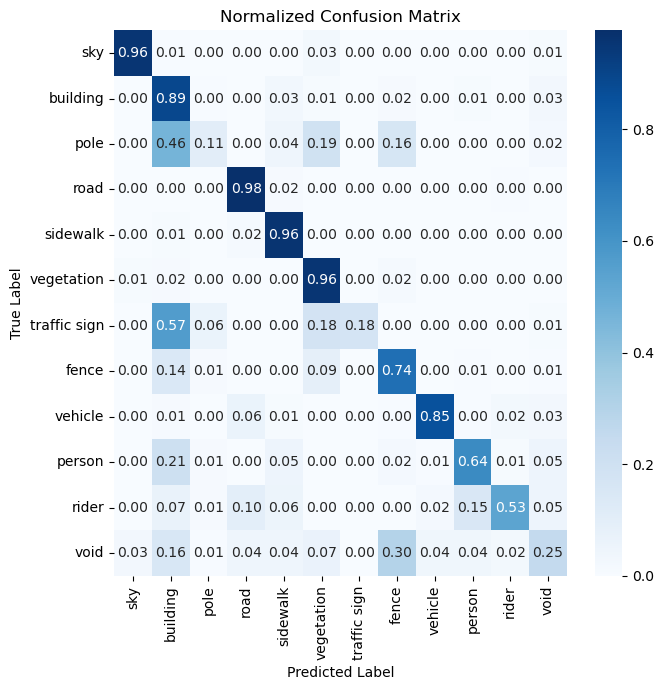

In [24]:
import seaborn as sns
import ast
import re
import io

df_temp = pd.read_csv(inf_metrics_path)

class_names = labels_df['label'].tolist() if 'label' in labels_df.columns else [f'Class {i}' for i in range(conf_matrix.shape[0])]

for ix, (index, row) in enumerate(df_temp.iterrows()):
    print(row)
    title = f"{row['Architecture']} {row['Loss Function']}"

    # pd read the value as string, we have to convert it back
    # Insert commas between numbers if missing
    num_classes = len(class_names)
    raw_str = row['Confusion Matrix']
    flat = np.fromstring(raw_str.replace('[', '').replace(']', ''), sep=' ')

    conf_matrix = flat.reshape((num_classes, num_classes))
    plt.figure(figsize=(7, 7))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()
    print()
    print()



## View Inference Result and Compare with Ground Truth

In [25]:
from PIL import Image
import torchvision.transforms as transforms
from dataset import data_transforms
import matplotlib.patches as mpatches


def unnormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean


def show_inference(image_path, mask_path, model, labels_df):

  image_raw = Image.open(image_path).convert("RGB")
  image_np = np.array(image_raw)
  mask_raw = Image.open(mask_path).convert("L")
  mask_np = np.array(mask_raw)

  output = data_transforms(image=image_np, mask=mask_np)
  image = output['image']
  masks = output['mask']

  image = image.unsqueeze(0) # add batch so that it [num_classes, H, W] to [1, num_classes, H, W]
                            
  with torch.no_grad():  # Disable gradient computation (faster inference)
      image = image.to(device)
      output = model(image)  # Forward pass (shape: [1, num_classes, H, W])
      
      # Apply softmax if not included in the model
      probabilities = torch.softmax(output, dim=1)  
      
      # Get predicted class indices (argmax over channels)
      predictions = torch.argmax(probabilities, dim=1)


  # resize predictions to match with mask size
  pred_np = predictions.squeeze().cpu().numpy()  # Shape: [H, W]
  pred_mask = Image.fromarray(pred_np.astype(np.uint8))
  resized_pred_mask = pred_mask.resize((mask_np.shape[1], mask_np.shape[0]), resample=Image.NEAREST)
  resized_preds_np = np.array(resized_pred_mask)


  # Extract class labels
  class_labels = labels_df['label'].tolist()

  # Use consistent colormap (same as used for mask display)
  cmap = plt.get_cmap("nipy_spectral", len(class_labels))

  # Create patch handles for each class
  legend_handles = [
      mpatches.Patch(color=cmap(i), label=class_labels[i])
      for i in range(len(class_labels))
  ]


  # Plotting
  fig, axes = plt.subplots(1, 3, figsize=(18, 6))
      
  axes[0].imshow(image_raw)
  axes[0].set_title("Original Image")
  axes[0].axis("off")

  axes[1].imshow(mask_raw, cmap="nipy_spectral")
  axes[1].set_title("Ground Truth Mask")
  axes[1].axis("off")

  axes[2].imshow(resized_preds_np, cmap="nipy_spectral")
  axes[2].set_title("Predicted Mask")
  axes[2].axis("off")

  fig.legend(
      handles=legend_handles,
      loc="lower center",
      ncol=4,  # Adjust columns for layout
      frameon=False,
      fontsize="medium"
  )
  plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
  plt.show()


FCN8s, Loss Function: Dice Loss


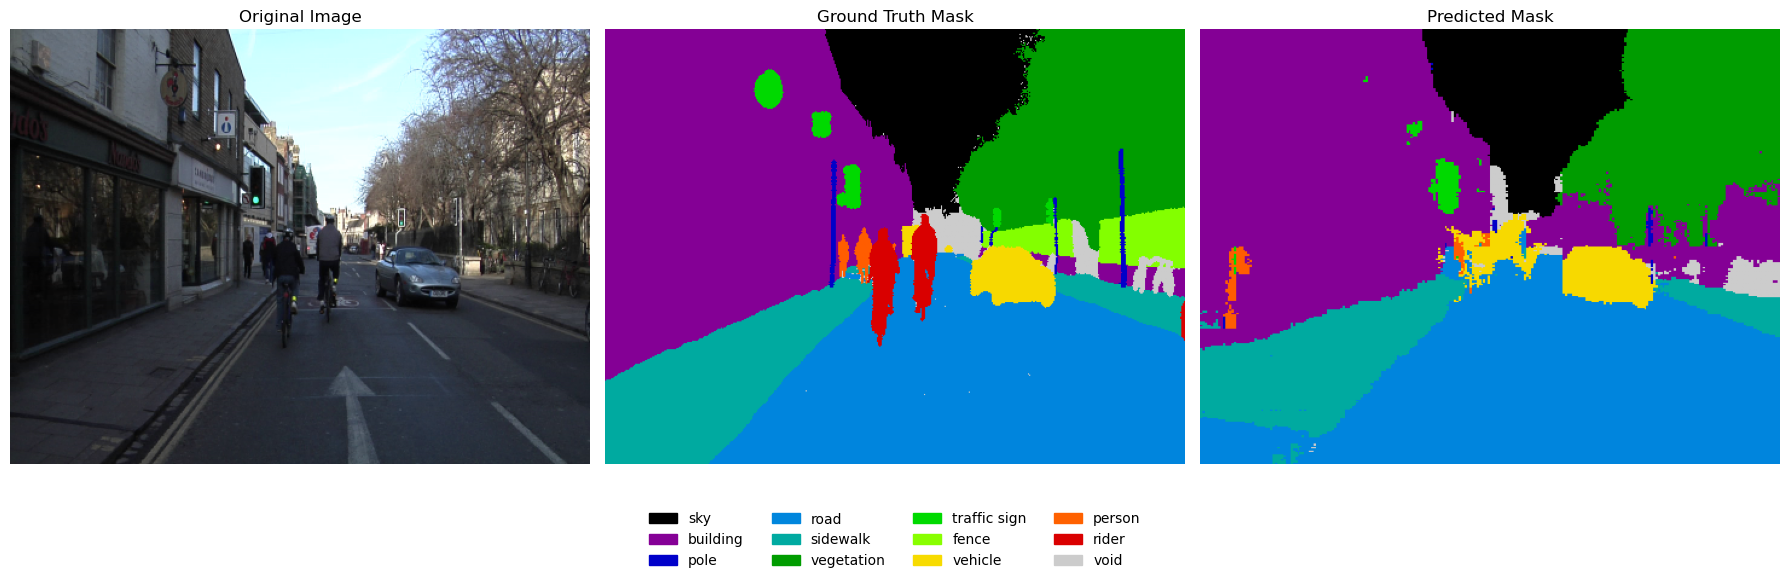

FCN8s, Loss Function: Cross Entropy Loss


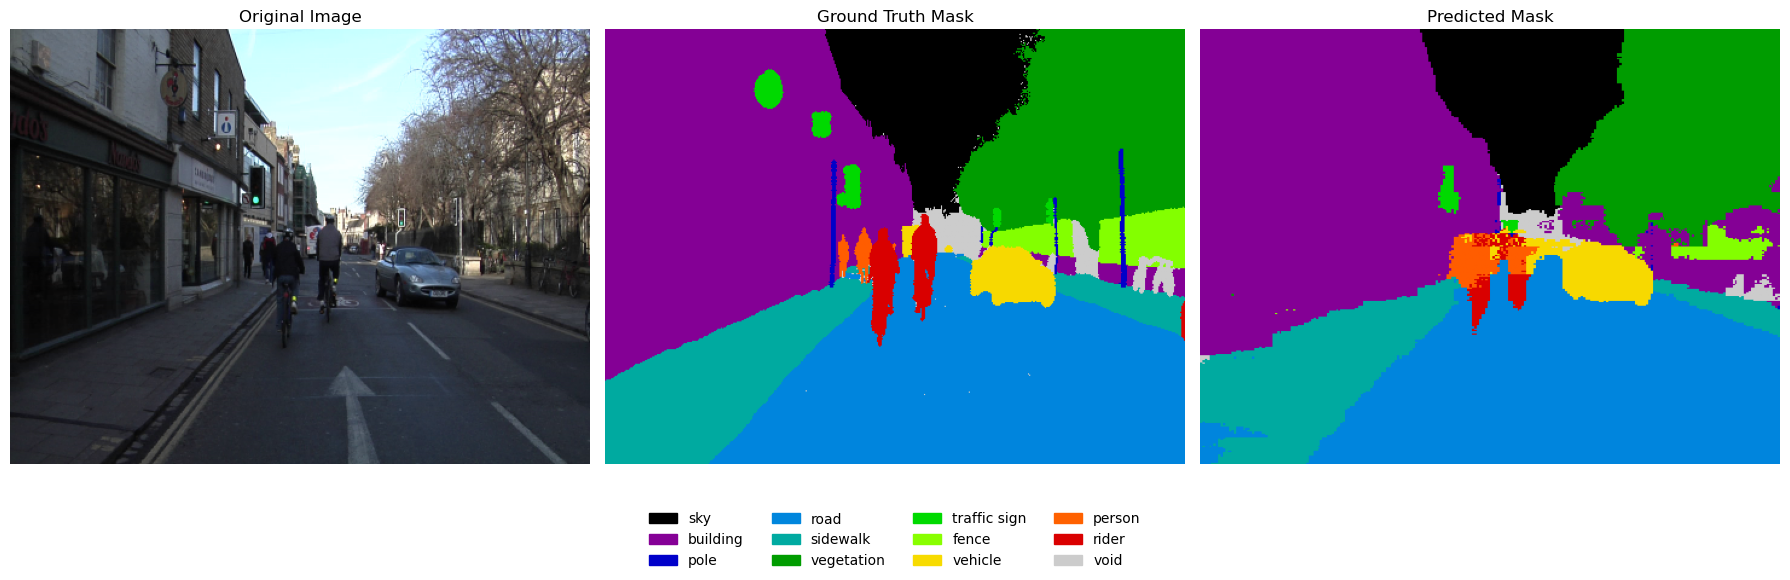

FCN8s, Loss Function: Combined


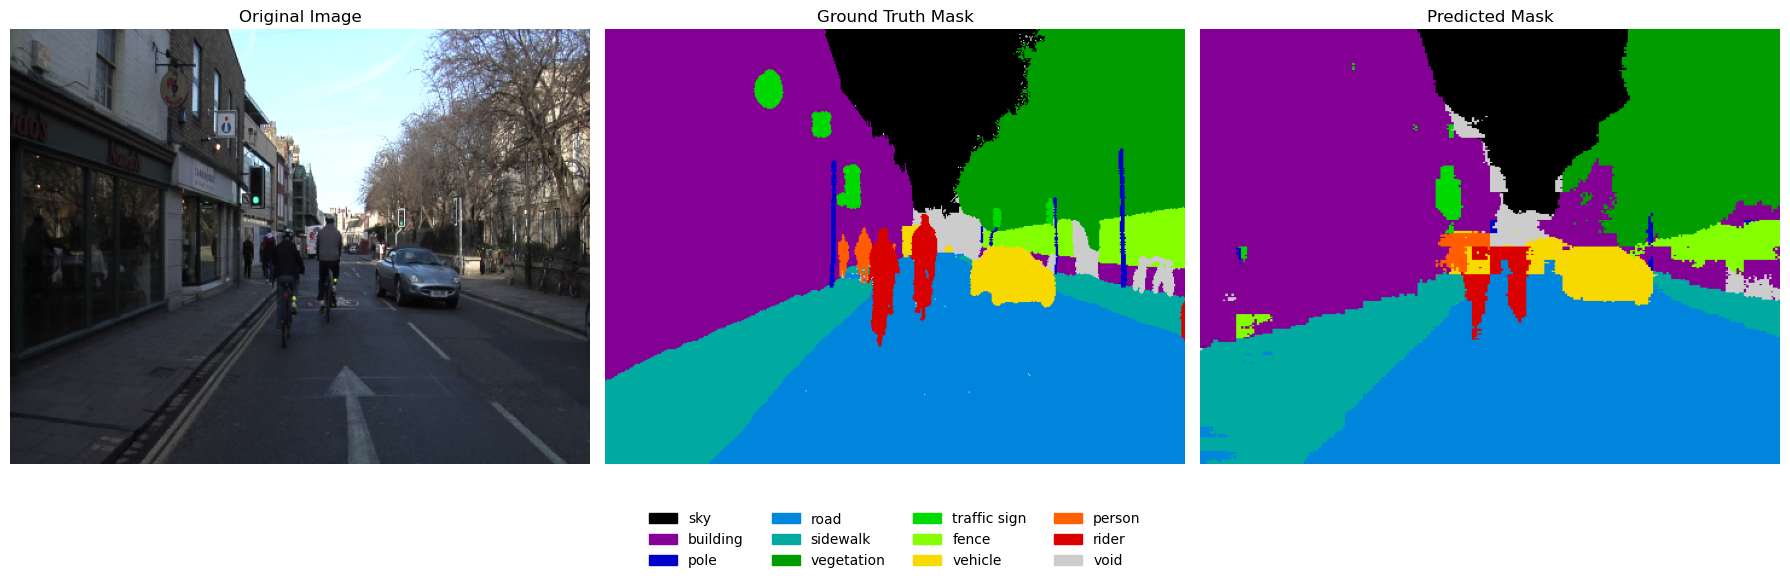

UNet, Loss Function: Dice Loss


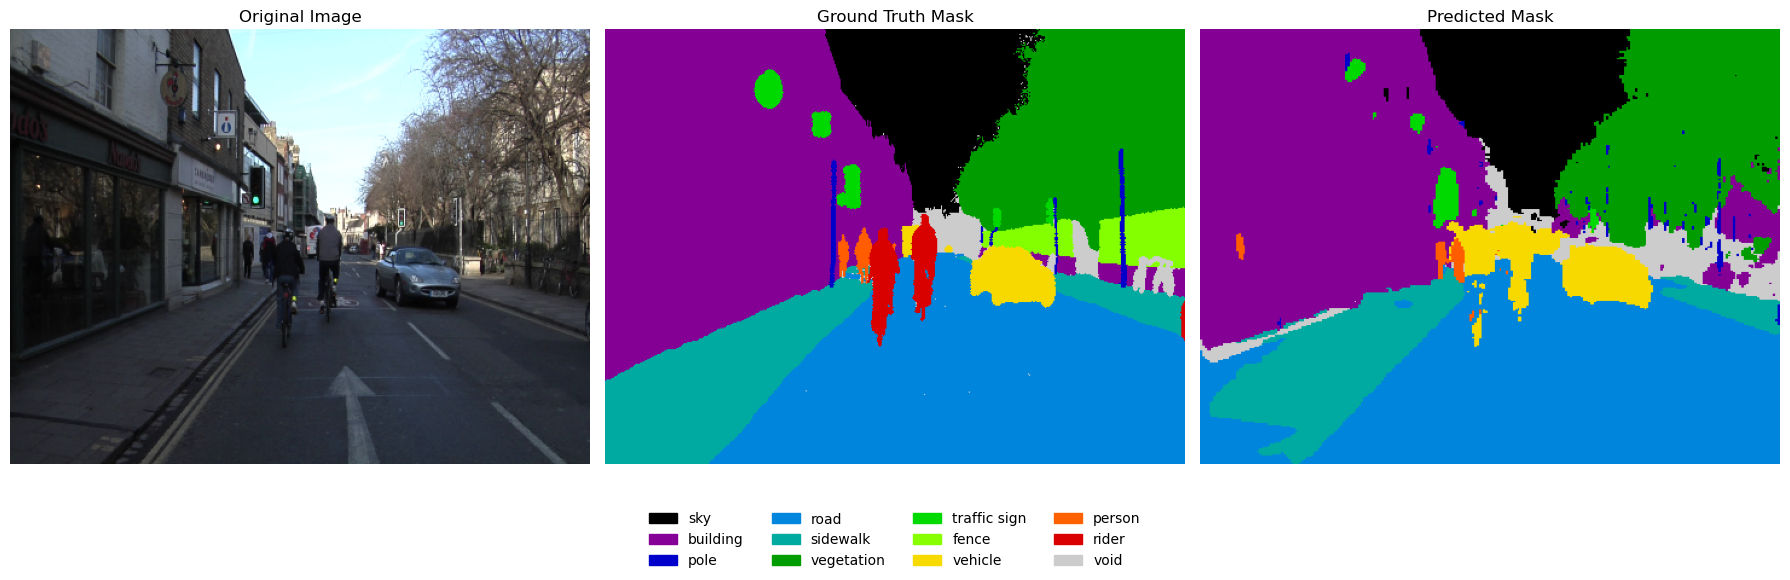

UNet, Loss Function: Cross Entropy Loss


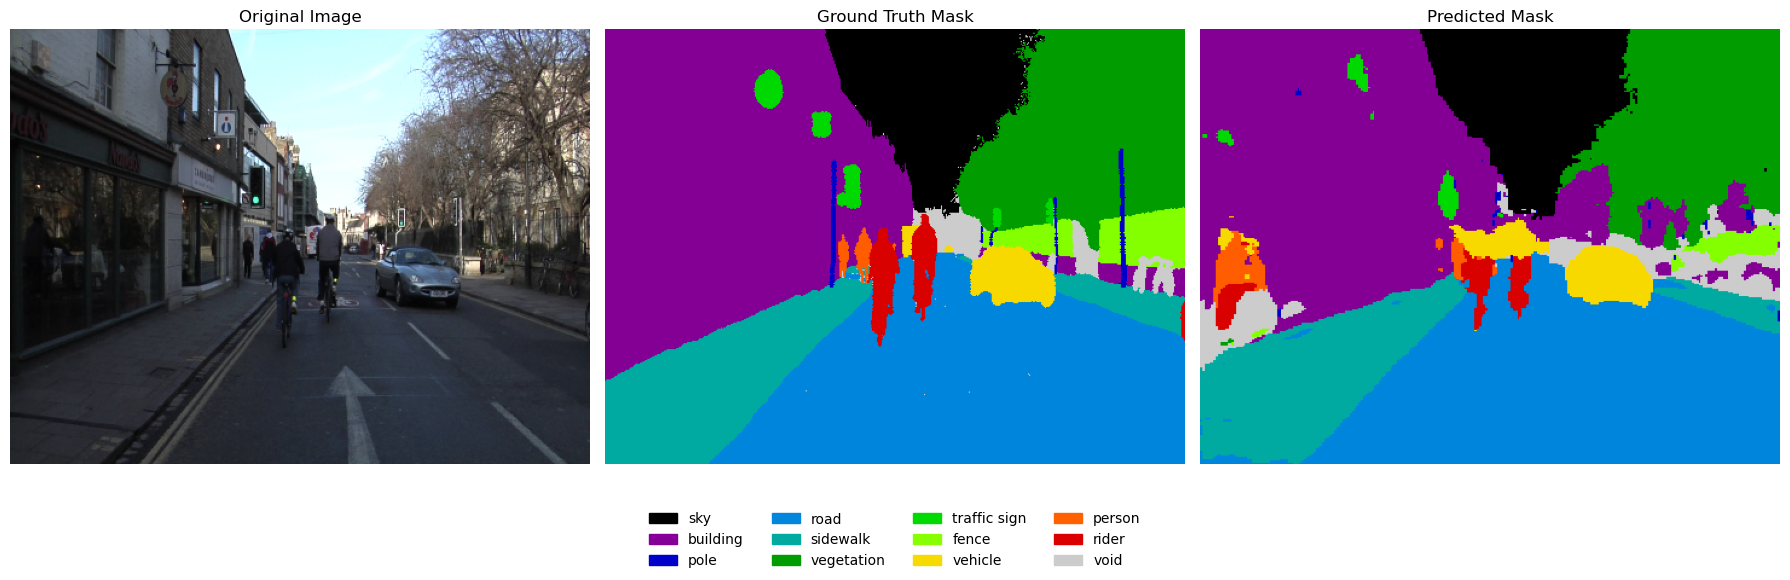

UNet, Loss Function: Combined


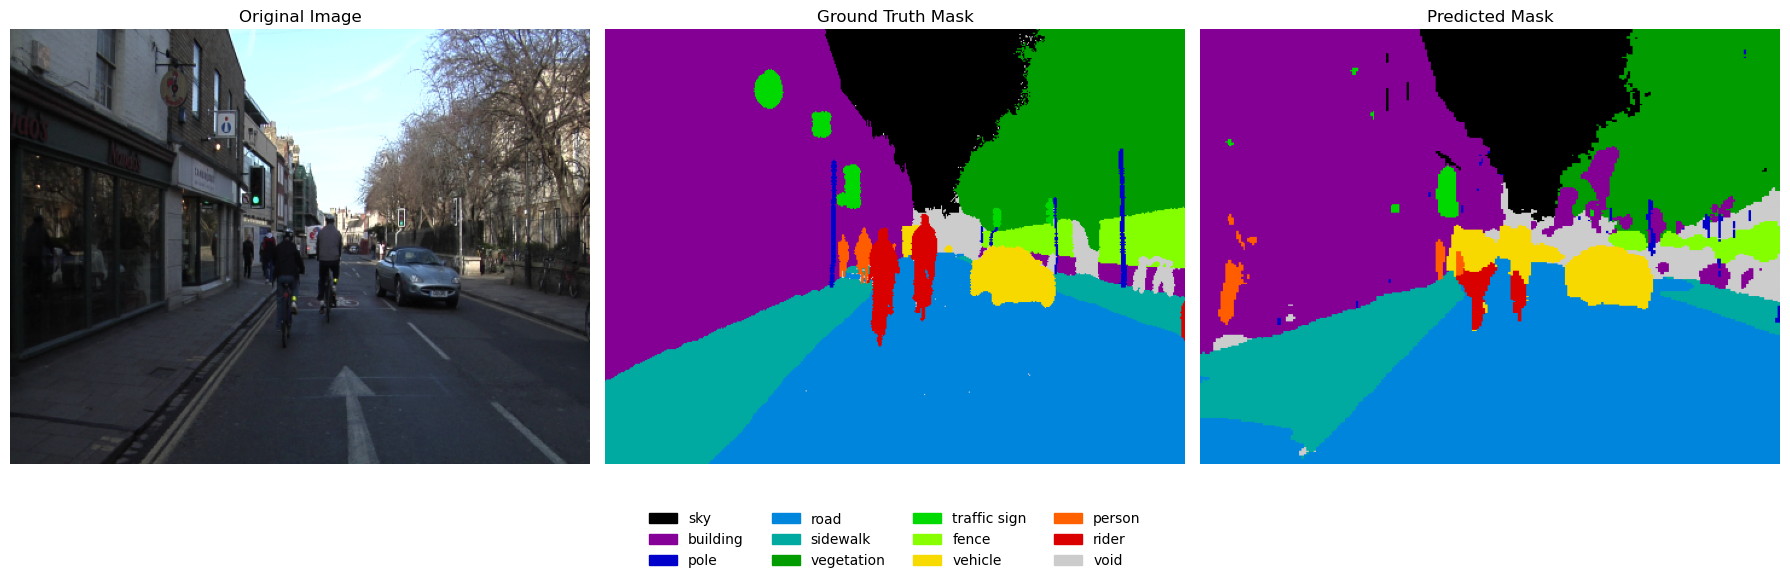

In [26]:

ix = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_path = os.path.join(TEST_IMG_PATH, test_files[ix])
mask_path = os.path.join(TEST_MASK_PATH, test_files[ix])


states = [['best_model_dice.pth', 'Dice Loss'],['best_model_cross.pth', 'Cross Entropy Loss'],['best_model_combined.pth','Combined']] 

model = FCN8s(in_channels=3, out_channels=len(labels_df))
model = model.to(device)
for state, lf in states:
    state_dict = torch.load(os.path.join(MODEL_PATH_FCN8S, state), weights_only=True)
    missing, unexpected = model.load_state_dict(state_dict)
    print(f'FCN8s, Loss Function: {lf}') 
    show_inference(image_path, mask_path, model, labels_df)


model = UNET(in_channels=3, out_channels=len(labels_df))
model = model.to(device)
for state, lf in states:
    state_dict = torch.load(os.path.join(MODEL_PATH, state), weights_only=True)
    missing, unexpected = model.load_state_dict(state_dict)
    print(f'UNet, Loss Function: {lf}') 
    show_inference(image_path, mask_path, model, labels_df)



## Additional metrics: Training vs Validation Loss / Epoch

    epoch  train_loss  val_loss
0       0    0.863680  0.912109
1       1    0.750827  0.911325
2       2    0.726097  0.816498
3       3    0.711652  0.814775
4       4    0.702422  0.829317
..    ...         ...       ...
95     95    0.542663  0.707434
96     96    0.542009  0.718670
97     97    0.541665  0.709243
98     98    0.540386  0.715905
99     99    0.539261  0.718001

[100 rows x 3 columns]


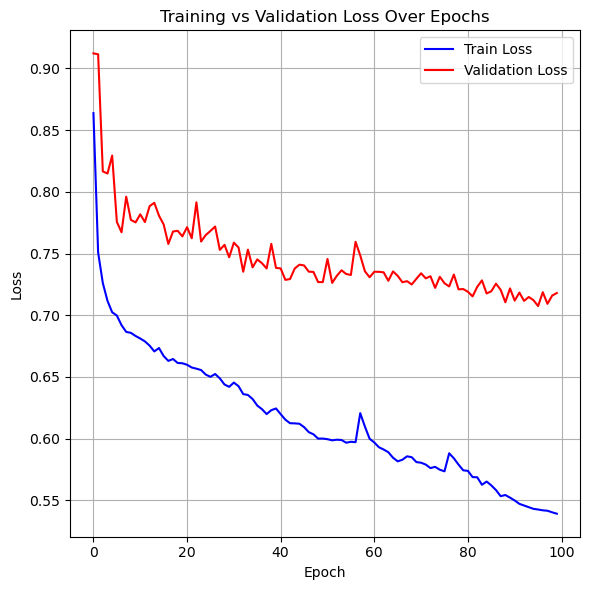

In [27]:
df = pd.read_csv(os.path.join(METRIC_PATH, 'train_fcn8s_dice.csv'))
print(df)
# Assuming df is your DataFrame with 'epoch', 'train_loss', and 'val_loss'
plt.figure(figsize=(6, 6))

# Plot training loss in blue
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')

# Plot validation loss in red
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='red')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


    epoch  train_loss  val_loss
0       0    1.591759  2.230048
1       1    0.978505  2.605362
2       2    0.831895  0.992687
3       3    0.747989  0.908145
4       4    0.682275  0.807408
..    ...         ...       ...
95     95    0.104371  0.431425
96     96    0.104273  0.374153
97     97    0.100643  0.414609
98     98    0.097906  0.401730
99     99    0.096619  0.399914

[100 rows x 3 columns]


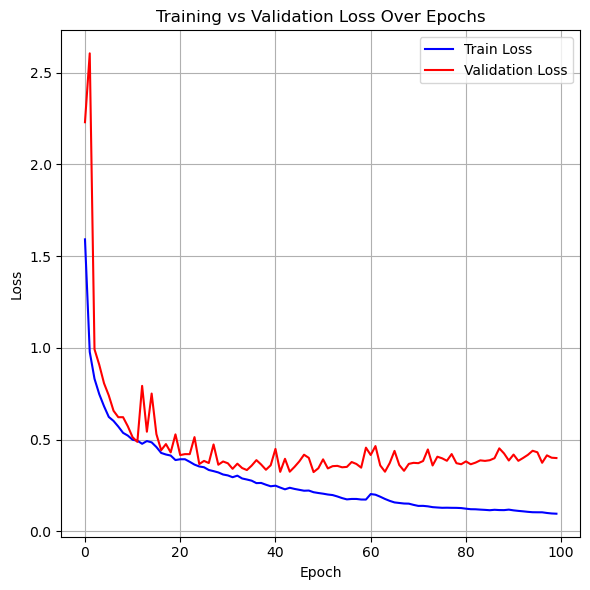

In [28]:
df = pd.read_csv(os.path.join(METRIC_PATH, 'train_fcn8s_cross.csv'))
print(df)
# Assuming df is your DataFrame with 'epoch', 'train_loss', and 'val_loss'
plt.figure(figsize=(6, 6))

# Plot training loss in blue
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')

# Plot validation loss in red
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='red')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


    epoch  train_loss  val_loss
0       0    1.193348  4.544333
1       1    0.851506  2.456887
2       2    0.747985  0.880624
3       3    0.698256  0.683399
4       4    0.644689  0.647635
..    ...         ...       ...
95     95    0.164031  0.435247
96     96    0.161276  0.444924
97     97    0.157968  0.431819
98     98    0.156566  0.423328
99     99    0.156199  0.439296

[100 rows x 3 columns]


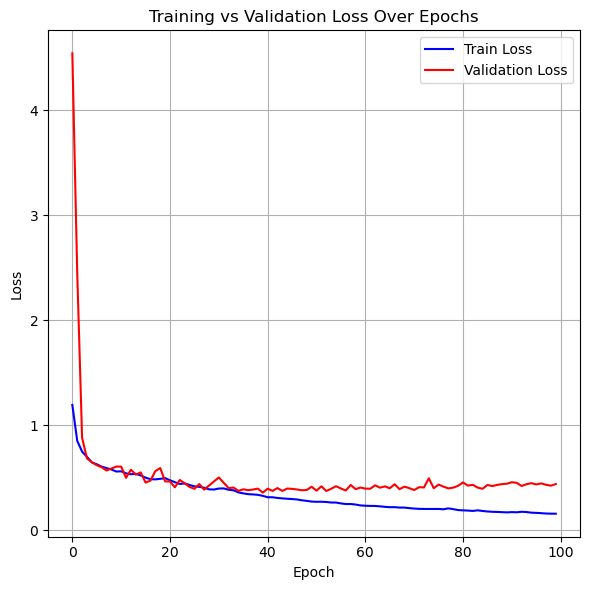

In [29]:
df = pd.read_csv(os.path.join(METRIC_PATH, 'train_fcn8s_combined.csv'))
print(df)
# Assuming df is your DataFrame with 'epoch', 'train_loss', and 'val_loss'
plt.figure(figsize=(6, 6))

# Plot training loss in blue
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')

# Plot validation loss in red
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='red')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


    epoch  train_loss  val_loss
0       0    0.892761  0.930569
1       1    0.849592  0.844009
2       2    0.821502  0.820724
3       3    0.794830  0.791698
4       4    0.764518  0.786259
..    ...         ...       ...
95     95    0.566727  0.712148
96     96    0.565776  0.706310
97     97    0.563811  0.706575
98     98    0.563166  0.712598
99     99    0.562390  0.711989

[100 rows x 3 columns]


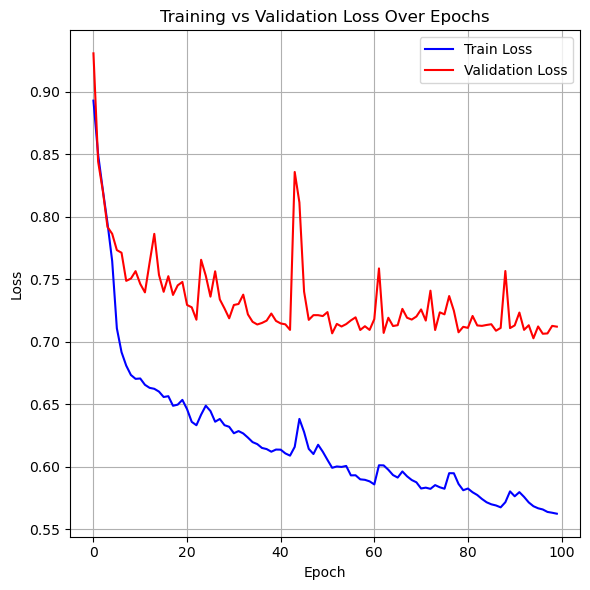

In [30]:
df = pd.read_csv(os.path.join(METRIC_PATH, 'train_unet_dice.csv'))
print(df)
# Assuming df is your DataFrame with 'epoch', 'train_loss', and 'val_loss'
plt.figure(figsize=(6, 6))

# Plot training loss in blue
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')

# Plot validation loss in red
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='red')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


    epoch  train_loss  val_loss
0       0    1.674622  2.003402
1       1    1.192708  3.078121
2       2    0.995163  1.402602
3       3    0.855686  1.035870
4       4    0.764664  1.054222
..    ...         ...       ...
95     95    0.136749  0.336676
96     96    0.132788  0.312850
97     97    0.131628  0.345005
98     98    0.128200  0.333987
99     99    0.126112  0.300514

[100 rows x 3 columns]


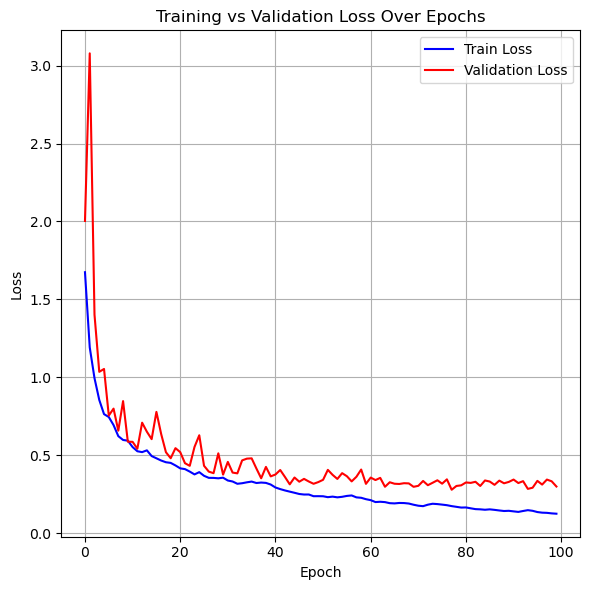

In [31]:
df = pd.read_csv(os.path.join(METRIC_PATH, 'train_unet_cross.csv'))
print(df)
# Assuming df is your DataFrame with 'epoch', 'train_loss', and 'val_loss'
plt.figure(figsize=(6, 6))

# Plot training loss in blue
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')

# Plot validation loss in red
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='red')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


    epoch  train_loss  val_loss
0       0    1.269503  1.561850
1       1    0.980835  1.569082
2       2    0.864047  0.970187
3       3    0.802764  0.772091
4       4    0.731039  0.698377
..    ...         ...       ...
95     95    0.221044  0.362508
96     96    0.227105  0.361080
97     97    0.222524  0.374592
98     98    0.212513  0.348775
99     99    0.206699  0.353857

[100 rows x 3 columns]


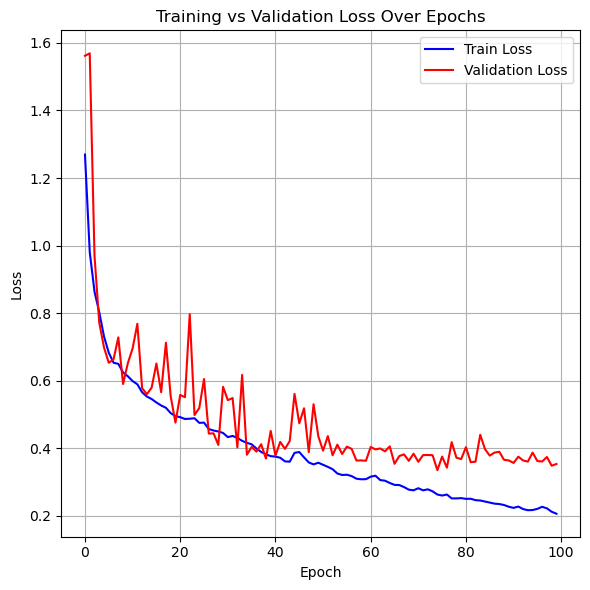

In [32]:
df = pd.read_csv(os.path.join(METRIC_PATH, 'train_unet_combined.csv'))
print(df)
# Assuming df is your DataFrame with 'epoch', 'train_loss', and 'val_loss'
plt.figure(figsize=(6, 6))

# Plot training loss in blue
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')

# Plot validation loss in red
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='red')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
